<a href="https://colab.research.google.com/github/War-Eagl/ds-notebooks/blob/master/plantpathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
!cp '/content/drive/My Drive/archive.zip' '/content'  

In [4]:
!unzip archive.zip

Archive:  archive.zip
  inflating: images/Test_0.jpg       
  inflating: images/Test_1.jpg       
  inflating: images/Test_10.jpg      
  inflating: images/Test_100.jpg     
  inflating: images/Test_1000.jpg    
  inflating: images/Test_1001.jpg    
  inflating: images/Test_1002.jpg    
  inflating: images/Test_1003.jpg    
  inflating: images/Test_1004.jpg    
  inflating: images/Test_1005.jpg    
  inflating: images/Test_1006.jpg    
  inflating: images/Test_1007.jpg    
  inflating: images/Test_1008.jpg    
  inflating: images/Test_1009.jpg    
  inflating: images/Test_101.jpg     
  inflating: images/Test_1010.jpg    
  inflating: images/Test_1011.jpg    
  inflating: images/Test_1012.jpg    
  inflating: images/Test_1013.jpg    
  inflating: images/Test_1014.jpg    
  inflating: images/Test_1015.jpg    
  inflating: images/Test_1016.jpg    
  inflating: images/Test_1017.jpg    
  inflating: images/Test_1018.jpg    
  inflating: images/Test_1019.jpg    
  inflating: images/Test_102

In [0]:
df_train=pd.read_csv('train.csv')

In [6]:
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [0]:
np.random.seed(42)
src = (ImageList.from_df(df_train, '/content', folder='images', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(cols=['healthy','multiple_diseases','rust','scab'],label_cls=MultiCategoryList))

In [0]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
data = (src.transform(tfms, size=100)
        .databunch().normalize(imagenet_stats))

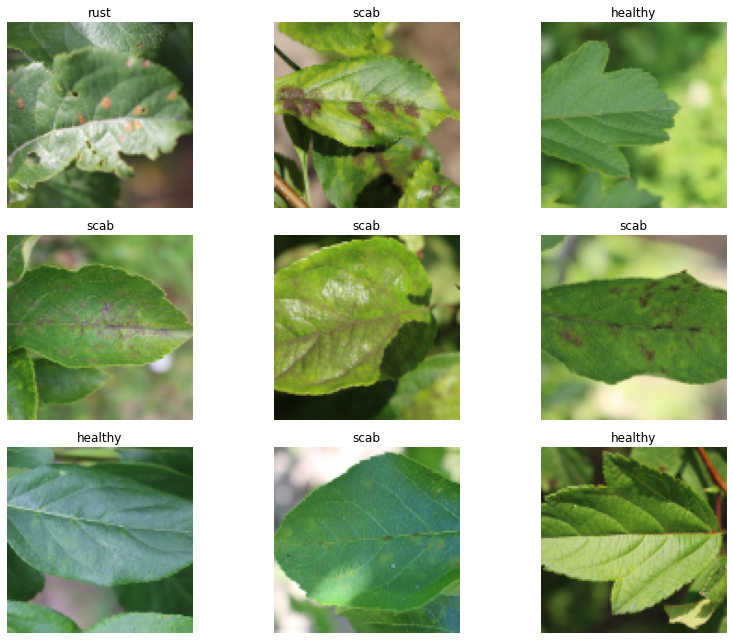

In [10]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch=models.densenet121

In [51]:
learn = cnn_learner(data, arch, metrics=fbeta)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [0]:
learn.freeze()

In [54]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


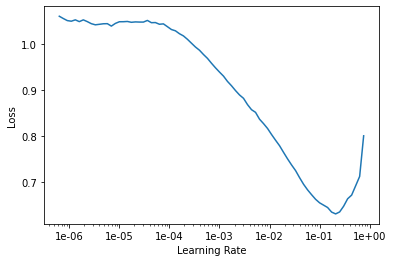

In [55]:
learn.recorder.plot()

In [0]:
lr = 0.03

In [57]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta,time
0,0.554030,0.232617,0.839874,02:34
1,0.331283,0.161626,0.886578,02:31
2,0.230560,0.137764,0.905678,02:33
3,0.163728,0.093266,0.948260,02:35
4,0.118323,0.090816,0.942766,02:34


In [0]:
learn.save('stage1_densenet')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


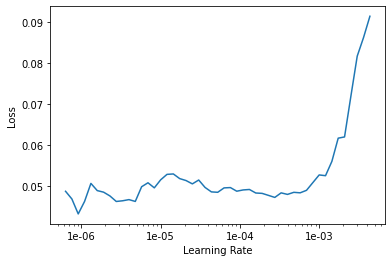

In [60]:
learn.lr_find()
learn.recorder.plot()

In [62]:
learn.fit_one_cycle(3,slice(1e-4))

epoch,train_loss,valid_loss,fbeta,time
0,0.047712,0.077965,0.954212,02:32
1,0.050715,0.071902,0.957418,02:34
2,0.044792,0.075534,0.957875,02:33


In [0]:
learn.save('Stage2_densenet')

In [64]:
data = (src.transform(tfms, size=200)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 200, 200])

In [0]:
learn.freeze()

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


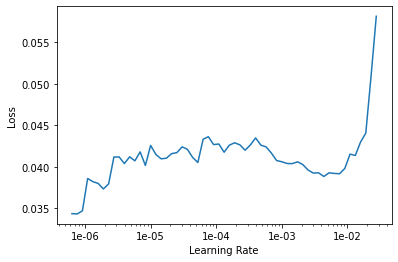

In [67]:
learn.recorder.plot()

In [0]:
lr=1e-03

In [69]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,fbeta,time
0,0.047363,0.080300,0.954670,02:35
1,0.040834,0.074092,0.957875,02:32
2,0.043244,0.067754,0.961081,02:33


In [0]:
learn.save('stage3_densenet')

In [71]:
learn.unfreeze()

<bound method Learner.unfreeze of Learner(data=ImageDataBunch;

Train: LabelList (1457 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: MultiCategoryList
scab,multiple_diseases,healthy,rust,healthy
Path: /content;

Valid: LabelList (364 items)
x: ImageList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: MultiCategoryList
rust,healthy,healthy,rust,healthy
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, 

In [0]:
learn.fit_one_cycle(1, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,fbeta,time
0,0.073822,0.099045,0.945775,02:27


In [72]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


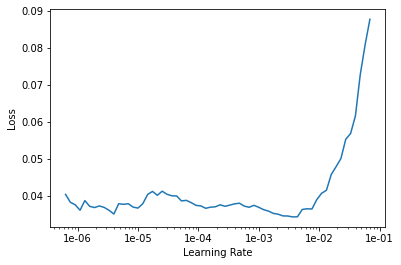

In [73]:
learn.recorder.plot()

In [76]:
learn.fit_one_cycle(1,slice(1e-3))

epoch,train_loss,valid_loss,fbeta,time
0,0.035147,0.071891,0.960623,02:34


In [0]:
learn.save("stage4_densenet")

In [0]:
learn=learn.load("stage4_densenet")

In [0]:
df_test=pd.read_csv('test.csv')

In [0]:
path='/content/images/'

In [82]:
df_test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [83]:
df_test['image_id'][4]

'Test_4'

In [0]:
file_names=[path+df_test['image_id']+'.jpg']

In [85]:
img=open_image(path+df_test['image_id'][4]+'.jpg')
learn.predict(img)[2].tolist()

[2.8053665346305934e-07,
 4.479300969251199e-06,
 0.9999998807907104,
 2.3172283647454606e-08]

In [86]:
ypred=[]
type(ypred)

list

In [0]:
??ypred.append()

In [0]:
for i in range(0,1821):
  img=open_image(path+df_test['image_id'][i]+'.jpg')
  pred=learn.predict(img)[2].tolist()
  ypred.append(pred)

In [0]:

for i in range(0,5):
  print(i)

0
1
2
3
4


In [88]:
df_test['image_id']

0          Test_0
1          Test_1
2          Test_2
3          Test_3
4          Test_4
          ...    
1816    Test_1816
1817    Test_1817
1818    Test_1818
1819    Test_1819
1820    Test_1820
Name: image_id, Length: 1821, dtype: object

In [89]:
ypred=ypred.tolist()

AttributeError: ignored

In [90]:
len(ypred)

1821

In [0]:
yhat=pd.DataFrame(ypred)

In [92]:
yhat.head()

,0,1,2,3
0,1.045823e-03,0.351965,0.946208,1.074391e-05
1,2.903901e-05,0.000180,0.999965,2.121404e-05
2,1.404921e-06,0.000002,0.000003,9.999996e-01
3,9.999989e-01,0.000002,0.000054,3.731776e-09
4,2.805367e-07,0.000004,1.000000,2.317228e-08


In [0]:
yhat.to_csv('/content/yhat.csv',index=False)

In [0]:
yhat=yhat.rename(columns={0:'healthy',1:'multiple_diseases',2:'rust',3:'scab'})

In [0]:
frames=[df_test,yhat]

In [0]:
result=pd.concat(frames,axis=1)

In [97]:
result.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.045823e-03,0.351965,0.946208,1.074391e-05
1,Test_1,2.903901e-05,0.000180,0.999965,2.121404e-05
2,Test_2,1.404921e-06,0.000002,0.000003,9.999996e-01
3,Test_3,9.999989e-01,0.000002,0.000054,3.731776e-09
4,Test_4,2.805367e-07,0.000004,1.000000,2.317228e-08


In [0]:
result.to_csv("/content/submission.csv")